In [ ]:
##### experimenting z gate locations with FT algo

In [56]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

print("imported")


imported


In [85]:

n = 10        # number of input qubits
# s = '1011'  # the binary hidden shift string
secret_var = np.random.randint(0, 2**n)
s = format(secret_var, "b").zfill(n) ### turns into a string 

In [86]:
display(n, secret_var, s)

10

946

'1110110010'

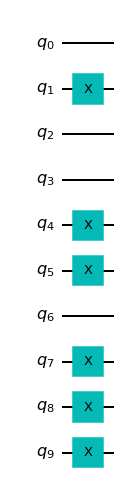

In [89]:
def shift_s(n, s):
    """Shifting operation for the given string s"""
    shift_s = QuantumCircuit(n)
    s = s[::-1]    # reverse s to fit qiskit's qubit ordering
    for i in range(n):
        if s[i] == '0': 
            continue
        else:
            shift_s.x(i)    # apply x gates to shift the input
    shift_s.name = 'Shift'
    return shift_s

# Display circuit
shift_s(n, s).draw('mpl')

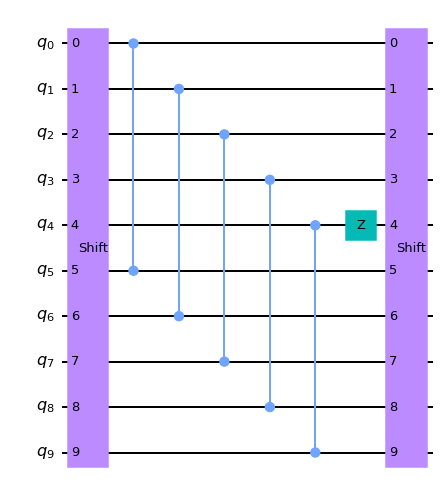

In [90]:
def oracle_g(n):
    """Oracle circuit that encodes g = U_g"""
    oracle_g = QuantumCircuit(n)
    
    # Shift the inputs
    oracle_g.append(shift_s(n, s), range(n))
    
    # Apply the oracle U_f = (-1)^f(x) = F(x)
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_g.cz(i, i+int(n/2))
    
    # h(x) = x·e_2 corresponds to the z gate on the second qubit = q1
    oracle_g.z(int(n/2)-1) ######### Z GATE APPLIED TO MIDDLE QUBIT
    
    # Undo the shift
    oracle_g.append(shift_s(n, s), range(n))
    
    oracle_g.name = 'Oracle g'
    return oracle_g

# Display circuit
oracle_g(n).draw()

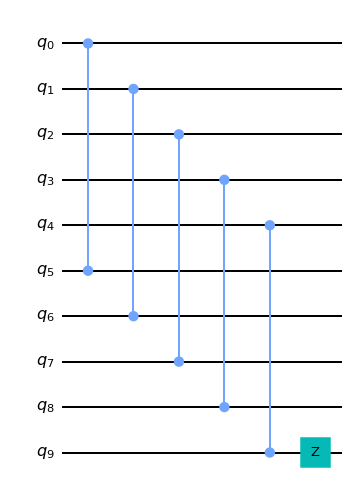

In [91]:
def oracle_f_tilde(n):
    """Oracle circuit that encodes Fourier transformed f = U_f tilde"""
    oracle_f_tilde = QuantumCircuit(n)
    
    # Apply the oracle U_f tilde
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_f_tilde.cz(i, i+int(n/2))
    
    # Apply h(y) = y·e_2, which corresponds to the z gate on the second qubit of the second register = q3
    oracle_f_tilde.z(int(n-1)) ########### Z GATE APPLIED TO LAST QUBIT OF LAST REGISTER WHICH SHOULD BE THE LAST QUBIT
    
    oracle_f_tilde.name = 'Oracle f tilde'
    return oracle_f_tilde

# Display circuit
oracle_f_tilde(n).draw('mpl')

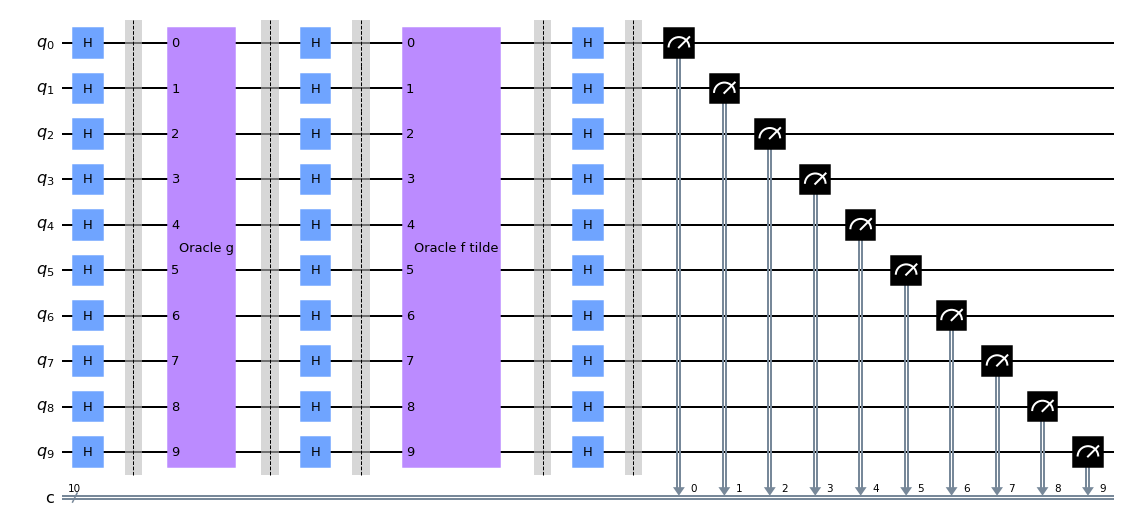

In [92]:
hsp_circuit = QuantumCircuit(n, n)

# Apply Hadamard gates to make superposition
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()    # barrier is for visual separation

# Query the oracle g by appending the oracle circuit on ours
hsp_circuit.append(oracle_g(n), range(n))
hsp_circuit.barrier()

# Apply Hadamard gates to perform a boolean Fourier transform
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Query the oracle f tilde
hsp_circuit.append(oracle_f_tilde(n), range(n))
hsp_circuit.barrier()

# Retrieve s by performing the boolean Fourier transform again
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Measure all qubits
for i in range(n):
    hsp_circuit.measure(i, i)

# Display circuit
hsp_circuit.draw('mpl')


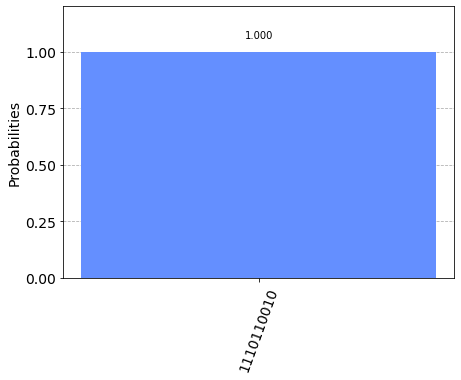

In [93]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)